# Stocks Prediction DOGE COIN
Dataset used -> https://www.openml.org/search?type=data&status=active&id=43472&sort=runs

Learning objectives:

- to transform raw data into meaningful, useful knowledge on a real world process or phenomena;
- to manage group work, divide tasks and collaborate on a data analysis project;
- to be able to define roles in a group and to agree on decisions;
- to give, evaluate and incorporate feedback;
- to efficiently report results of machine learning solutions.

In [1]:
from scipy.io import arff
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()
sns.set_style("darkgrid")

In [2]:
def load_arff_to_dataframe(file_path):
    """
    Load an ARFF file and convert it to a pandas DataFrame. 
    We need to make sure there are no string attributes as loadarff will fail.

    Parameters:
    file_path (str): The path to the ARFF file.

    Returns:
    pd.DataFrame: A DataFrame containing the data from the ARFF file.
    """
    data, meta = arff.loadarff(file_path)
    df = pd.DataFrame(data)
    df['Date'] = pd.to_datetime(df['Date']).dt.normalize()
    df['Volume'] = df['Volume'].astype(int)
    df = df.sort_values('Date').reset_index(drop=True)
    # set index
    df = df.set_index('Date')

    return df

In [3]:
df = load_arff_to_dataframe('dataset.arff')
df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2017-11-09,0.001207,0.001415,0.001181,0.001415,6259550
2017-11-10,0.001421,0.001431,0.001125,0.001163,4246520
2017-11-11,0.001146,0.001257,0.001141,0.001201,2231080
2017-11-12,0.001189,0.001210,0.001002,0.001038,3288960
2017-11-13,0.001046,0.001212,0.001019,0.001211,2481270


In [4]:
pd.set_option('display.float_format', '{:f}'.format)
df.describe()

,Open,High,Low,Close,Volume
count,1532.000000,1532.000000,1532.000000,1532.000000,1532.000000
mean,0.053032,0.056574,0.049593,0.053151,1049953580.579634
std,0.106257,0.114770,0.097944,0.106358,3809881008.653499
min,0.001046,0.001210,0.001002,0.001038,1431720.000000
25%,0.002494,0.002551,0.002430,0.002495,19654915.500000
50%,0.003161,0.003260,0.003059,0.003162,68068690.500000
75%,0.009115,0.009615,0.008515,0.009194,283732406.250000
max,0.687801,0.737567,0.608168,0.684777,69410680685.000000


### Time Series Visualization & Initial Exploration Analysis

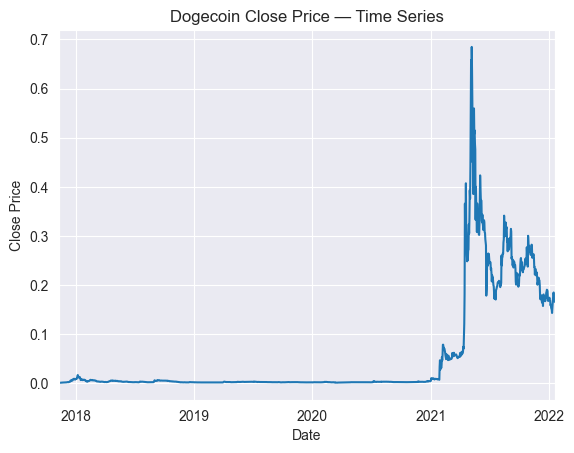

In [5]:
# Time-series line plot
fig, ax = plt.subplots()
df['Close'].plot(ax=ax, title='Dogecoin Close Price — Time Series')
ax.set_ylabel('Close Price')
plt.show()

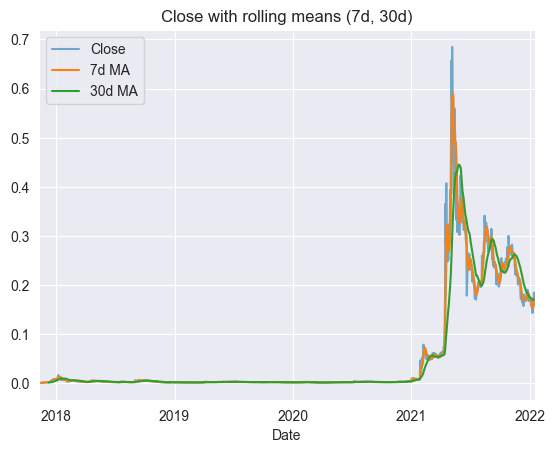

In [6]:
# Rolling stats: short and long window
fig, ax = plt.subplots()
df["Close"].plot(ax=ax, alpha=0.6, label='Close')
df["Close"].rolling(7).mean().plot(ax=ax, label='7d MA')
df["Close"].rolling(30).mean().plot(ax=ax, label='30d MA')
ax.legend()
ax.set_title('Close with rolling means (7d, 30d)')
plt.show()

### STL

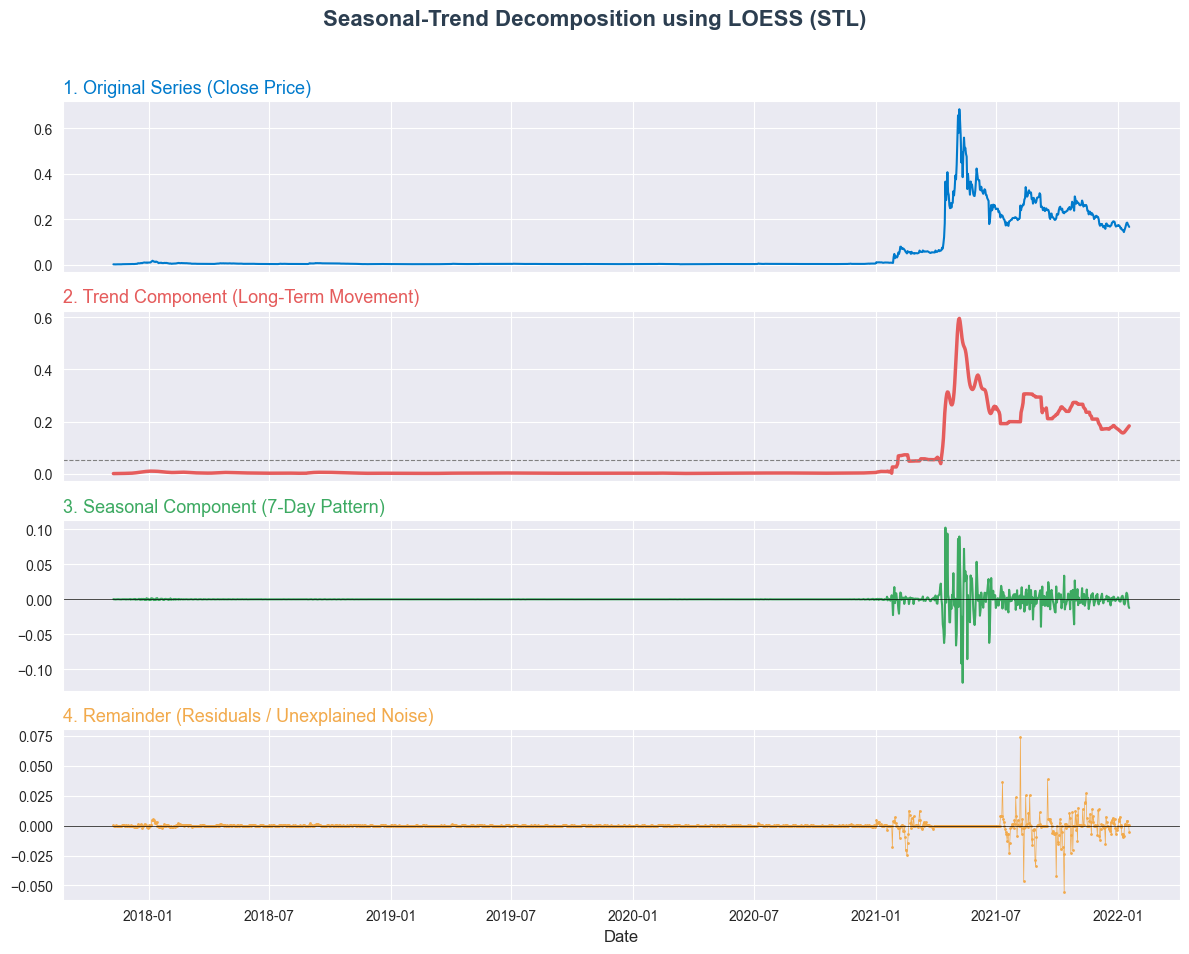

In [7]:
from statsmodels.tsa.seasonal import STL
# Season value can be tuned
# We will be using robust to handle potential outliers in the data
stl = STL(df['Close'], seasonal=7, robust=True)
res = stl.fit()

# Define distinct colors for visual separation
COLOR_ORIGINAL = '#007ACC'  # Deep Blue
COLOR_TREND = '#E55C5C'     # Muted Red
COLOR_SEASONAL = '#3DAA62'  # Medium Green
COLOR_RESIDUAL = '#F2AA4C'  # Warm Orange

# Create the figure with 4 stacked subplots, sharing the x-axis (time)
fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

# Main Title for the Entire Figure
fig.suptitle('Seasonal-Trend Decomposition using LOESS (STL)', fontsize=16, fontweight='bold', color='#2c3e50')

# 1. Original Series
axes[0].plot(df.index, df['Close'], color=COLOR_ORIGINAL, linewidth=1.5)
axes[0].set_title('1. Original Series (Close Price)', fontsize=13, loc='left', color=COLOR_ORIGINAL)
axes[0].tick_params(axis='y', labelsize=10)

# 2. Trend Component
axes[1].plot(df.index, res.trend, color=COLOR_TREND, linewidth=2.5)
axes[1].set_title('2. Trend Component (Long-Term Movement)', fontsize=13, loc='left', color=COLOR_TREND)
axes[1].tick_params(axis='y', labelsize=10)
axes[1].axhline(y=res.trend.mean(), color='grey', linestyle='--', linewidth=0.8) # Optional mean line

# 3. Seasonal Component
axes[2].plot(df.index, res.seasonal, color=COLOR_SEASONAL, linewidth=1.5)
axes[2].set_title('3. Seasonal Component (7-Day Pattern)', fontsize=13, loc='left', color=COLOR_SEASONAL)
axes[2].tick_params(axis='y', labelsize=10)
axes[2].axhline(0, color='black', linewidth=0.5)

# 4. Residual Component (The "Loss" or Remainder)
axes[3].plot(df.index, res.resid, color=COLOR_RESIDUAL, linewidth=0.5, marker='.', markersize=2)
axes[3].set_title('4. Remainder (Residuals / Unexplained Noise)', fontsize=13, loc='left', color=COLOR_RESIDUAL)
axes[3].tick_params(axis='y', labelsize=10)
axes[3].axhline(0, color='black', linewidth=0.5)

# Final Layout Adjustments
plt.xlabel('Date', fontsize=12)
# Improve the spacing between subplots
plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()

### Autocorrelation

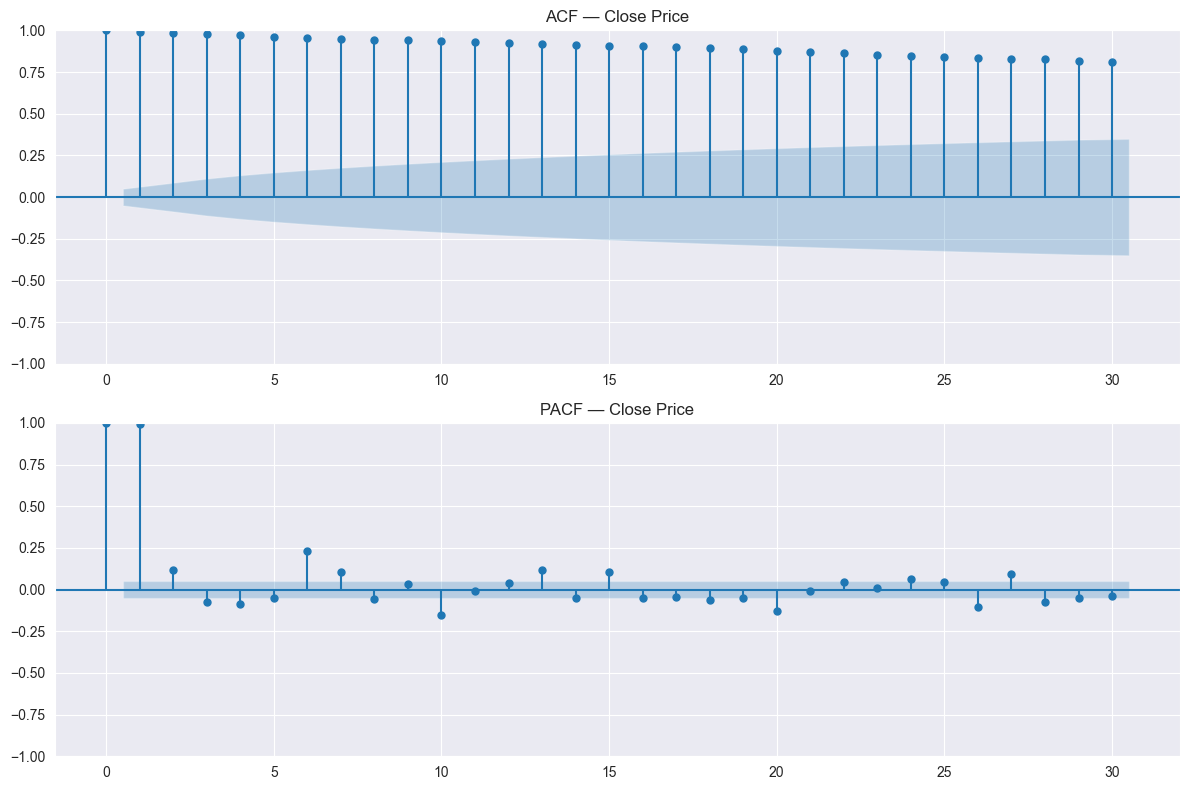

In [8]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

nlags = 30
# ACF and PACF plots (lags in days)
fig, ax = plt.subplots(2,1, figsize=(12,8))
plot_acf(df['Close'].dropna(), ax=ax[0], lags=nlags)
ax[0].set_title('ACF — Close Price')

plot_pacf(df['Close'].dropna(), ax=ax[1], lags=nlags) 
ax[1].set_title('PACF — Close Price')
plt.tight_layout()
plt.show()


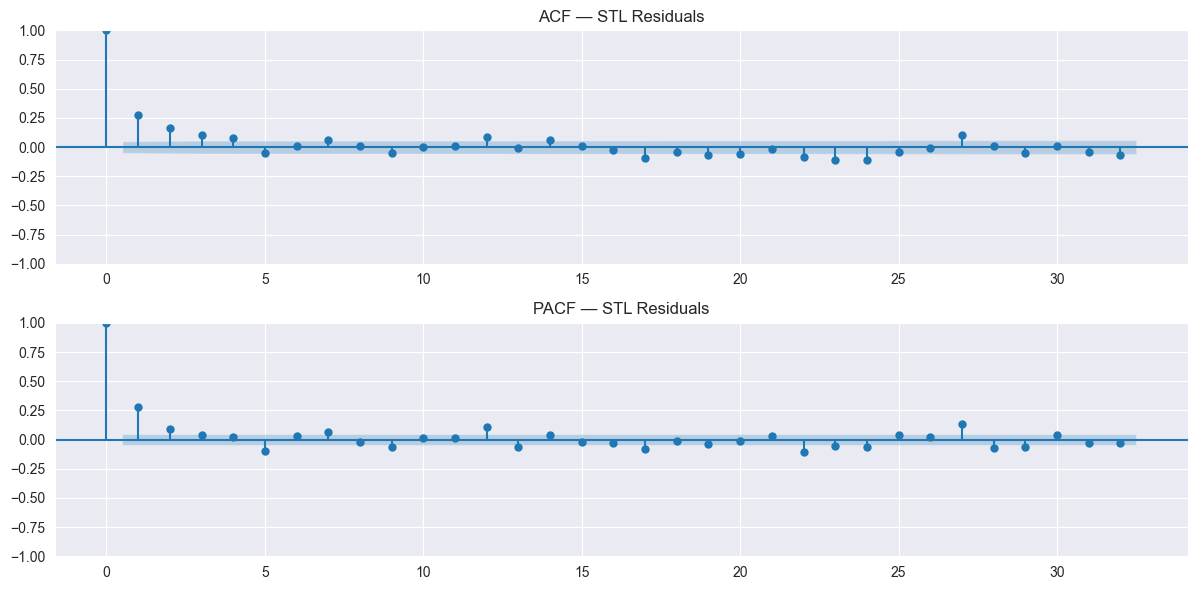

In [9]:
# Also check on residuals from STL to see if the decomposition removed autocorrelation
fig, ax = plt.subplots(2,1, figsize=(12,6))
plot_acf(res.resid.dropna(), ax=ax[0])
ax[0].set_title('ACF — STL Residuals')
plot_pacf(res.resid.dropna(), ax=ax[1])
ax[1].set_title('PACF — STL Residuals')
plt.tight_layout()
plt.show()

---

### Week 3

In [10]:
# DATA PRETREATMENT
df = df.asfreq('D')

# Check for missing values after resampling
print("Missing values per column after resampling:")
print(df.isna().sum())


Missing values per column after resampling:
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64


In [11]:
# Detect outliers using STL decomposition
from statsmodels.tsa.seasonal import STL

# STL decomposition to find residuals
stl_week3 = STL(df['Close'], period=7, robust=True) 
res_week3 = stl_week3.fit()
residuals = res_week3.resid

# Identify outliers
outliers = residuals[(residuals > residuals.mean() + 3*residuals.std()) |
                     (residuals < residuals.mean() - 3*residuals.std())]

print(f"\nNumber of outliers detected: {len(outliers)}")
print(outliers.head())



Number of outliers detected: 30
Date
2021-01-26   -0.017833
2021-02-15   -0.020405
2021-02-16   -0.020214
2021-02-17   -0.024841
2021-02-18   -0.014819
Name: resid, dtype: float64


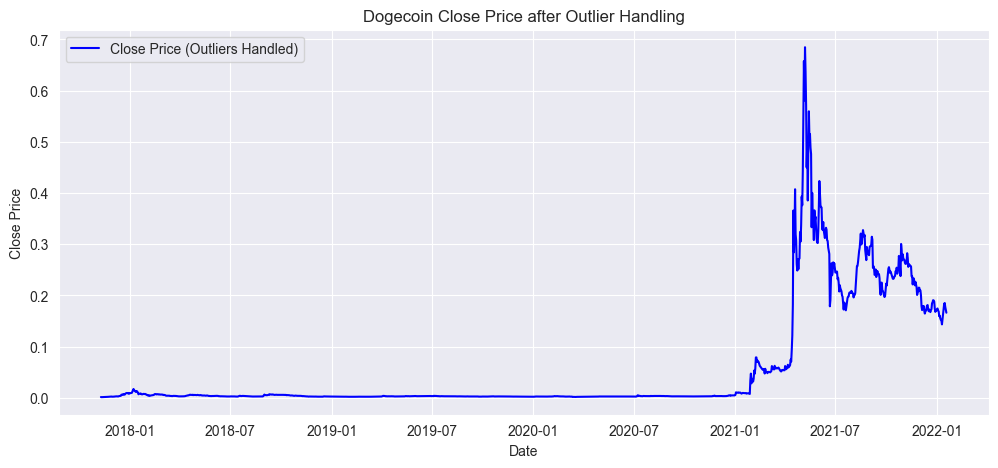

In [12]:
# Replace outliers in 'Close' with NaN, then interpolate
df['Close'] = df['Close'].mask((residuals > residuals.mean() + 3*residuals.std()) |
                                (residuals < residuals.mean() - 3*residuals.std()))
df['Close'] = df['Close'].interpolate(method='linear')

# Plot Close after outlier handling
plt.figure(figsize=(12,5))
plt.plot(df.index, df['Close'], label='Close Price (Outliers Handled)', color='blue')
plt.title('Dogecoin Close Price after Outlier Handling')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()


### Checkin if the data is stationary or non-stationary

In [ ]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(df['Close'])
print('p-value:', result[1])
#If p > 0.05 → series is non-stationary 

p-value: 0.2843025169145385


### Applying log transformation to transform the data from additive to multiplicative

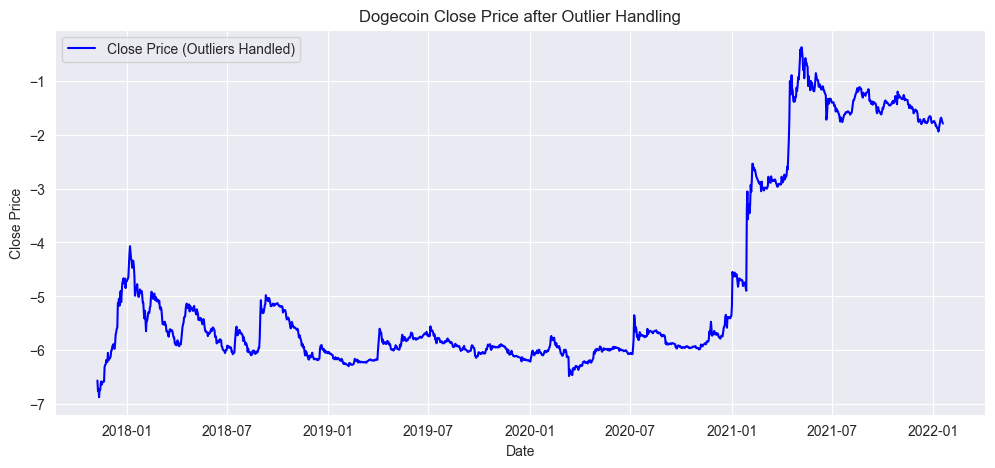

In [67]:
df["Close_log"] = np.log(df["Close"])

# Plot Close after outlier handling
plt.figure(figsize=(12,5))
plt.plot(df.index, df['Close_log'], label='Close Price (Outliers Handled)', color='blue')
plt.title('Dogecoin Close Price after Outlier Handling')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [68]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(df['Close_log'])
print('p-value:', result[1])
#If p > 0.05 → series is non-stationary 

p-value: 0.8700699314336873


### Creating a new column named difference to make the data stationary

/var/folders/r0/j25s34097z3202qp_htcbmc80000gn/T/ipykernel_72109/3994431623.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Close_diff_log"].fillna(0, inplace=True)


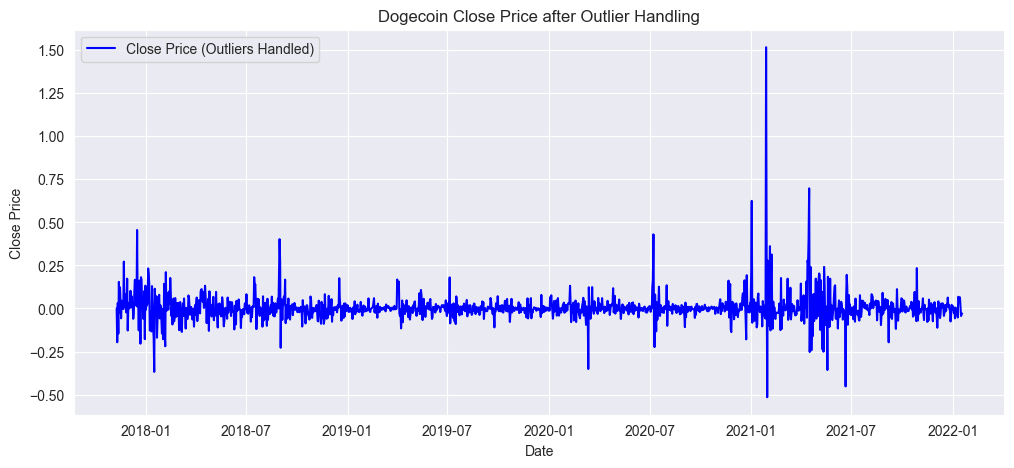

In [73]:
df["Close_diff_log"] = df["Close_log"].diff().dropna()
df["Close_diff_log"].fillna(0, inplace=True)

# Plot Close after outlier handling
plt.figure(figsize=(12,5))
plt.plot(df.index, df['Close_diff_log'], label='Close Price (Outliers Handled)', color='blue')
plt.title('Dogecoin Close Price after Outlier Handling')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [75]:
# Split data: 70% train, 30% test
train_size = int(len(df) * 0.7)
train, test = df['Close_diff_log'][:train_size], df['Close_diff_log'][train_size:]

### Finding out which lag would result in a good model

In [76]:
# To find out optimal lag based on AIC
from statsmodels.tsa.ar_model import AutoReg

results = {}
for lag in range(1, 30):  # try lags 1 to 14
    model = AutoReg(train, lags=lag).fit()
    results[lag] = model.aic

best_lag = min(results, key=results.get)
print("Best lag based on AIC:", best_lag)

Best lag based on AIC: 5



Baseline AR Model RMSE: 0.118988


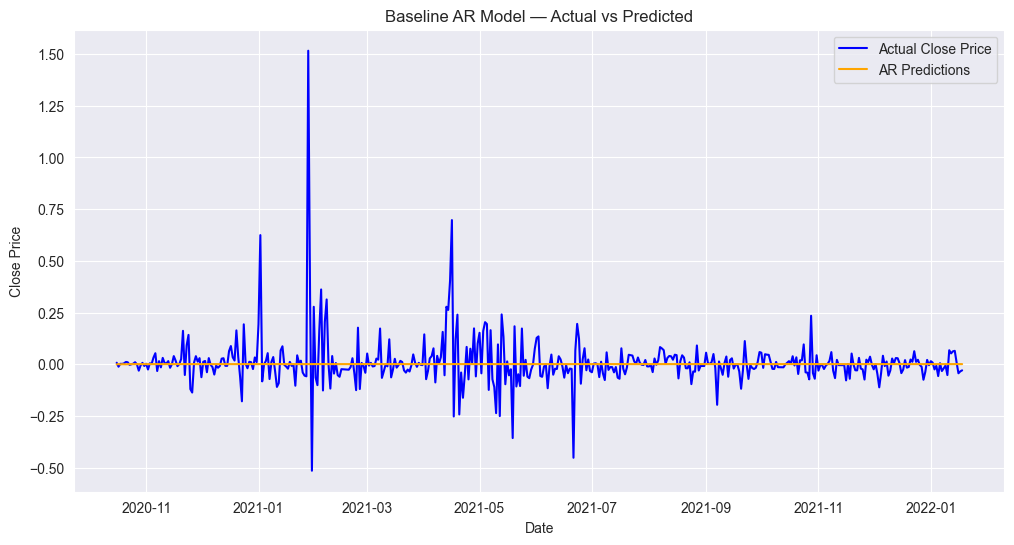

In [ ]:
# Baseline Autoregressive Model
from statsmodels.tsa.ar_model import AutoReg
import numpy as np
from sklearn.metrics import mean_squared_error

# Fit AR model with 7 lag days
ar_model = AutoReg(train, lags=7).fit()

# Predictions on test set
preds = ar_model.predict(
    start=test.index[0], 
    end=test.index[-1], 
    dynamic=False)

# Evaluate baseline performance
mse = mean_squared_error(test, preds)
rmse = np.sqrt(mse)
print(f"\nBaseline AR Model RMSE: {rmse:.6f}")

# Convert predictions back to price
# Last known log price before test period
last_train_log_price = df["Close"].loc[train.index[-1]]

price_preds = []
current_log_price = last_train_log_price
for r in preds:
    current_log_price += r
    price_preds.append(np.exp(current_log_price))

price_preds = pd.Series(price_preds, index=test.index)

# Plot AR predictions vs actual
plt.figure(figsize=(12,6))
plt.plot(test.index, test, label='Actual Close Price', color='blue')
plt.plot(test.index, preds, label='AR Predictions', color='orange')

plt.title('Baseline AR Model — Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()

plt.show()

# plt.figure(figsize=(12,6))
# plt.plot(df["Close"].loc[train.index], label='Train (Actual)', color='green')
# plt.plot(df["Close"].loc[test.index], label='Test (Actual)', color='blue')
# plt.plot(price_preds, label='AR Predictions', color='orange')
# plt.title('Baseline AR Model — Dogecoin Close Price')
# plt.xlabel('Date')
# plt.ylabel('Price (USD)')
# plt.legend()
# plt.show()

- The AR model produced a nearly flat line prediction (close to zero) on the differenced log transformed series. This indicates that the model primarily captured the mean of the return series, which is usually zero, suggesting that the model coefficients for past lags were insufficient or negligible compared to the series' overall volatility.

- The model failed completely to capture the large, unpredictable spikes (high variance) present in the differenced series. This failure arises because the basic AR model assumes constant variance (homoskedasticity) in its residuals, an assumption that is severely violated by crypto returns, which shows heteroskedasticity (time varying variance).

- The poor baseline performance confirms that a simple linear model like AR is inadequate for this task. It establishes the necessity of moving to more complex models like ARIMA or, more importantly Recurrent Neural Networks (RNN/LSTM), which are better equipped to capture the non linear, high frequency dependencies in the time series residuals.